
# Download Swot from AVISO
This notebook explains how to explore and retrieve available SWOT LR data from AVISO's THREDDS Data Server and FTP Server, presented [here](https://www.aviso.altimetry.fr/en/missions/current-missions/swot/access-to-data.html).

L2 data can be explored at: https://tds.aviso.altimetry.fr/thredds/L2/L2-SWOT-DATA/L2-SWOT.html

L3 data can be explored at: https://tds.aviso.altimetry.fr/thredds/L3/dataset-l3-swot-karin-nadir-pre-validated.html


## Tutorial Objectives
* Discover Aviso's Thredds Data Server catalogue
* Download files through HTTP and FTP
* Download data subset through Opendap



## Import + code



In [5]:
#pip install siphon

In [6]:
import os
import re
from getpass import getpass
import requests as rq
import ftplib
import xarray as xr
from xarray.backends import PydapDataStore
import pydap
from siphon.catalog import TDSCatalog
import numpy as np

def _get_filename_from_cd(cd):
    """ Get filename from content-disposition """
    if not cd:
        return None
    fname = re.findall('filename="(.+)"', cd)
    if len(fname) == 0:
        return None
    return fname[0]

def http_download_file(dataset_url:str, output_path:str,filename):
    response = rq.get(dataset_url, auth=(username, password))
    
    #filename = _get_filename_from_cd(response.headers['content-disposition']) # SR: this was giving me an error so I added filename is argument in function
    file_path = os.path.join(output_path, filename)
    
    open(file_path, 'wb').write(response.content)
    return file_path

def _download_file(ftp:str, filename:str, target_directory:str):
    try:
        local_filepath = os.path.join(target_directory, filename)
        with open(local_filepath, 'wb') as file:
            ftp.retrbinary('RETR %s' % filename, file.write)
            print(f"Downloaded {filename} to {target_directory}")
            return local_filepath
    except Exception as e:
        print(f"Error downloading {filename}: {e}")
        
def ftp_download_file(ftp_path:str, filename:str, output_path:str):
    # Set up FTP server details
    ftpAVISO = 'ftp-access.aviso.altimetry.fr'
    try:
        # Logging into FTP server using provided credentials
        with ftplib.FTP(ftpAVISO) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_path)
            print(f"Connection Established {ftp.getwelcome()}")

            # Check if the file exists in the directory
            if filename in ftp.nlst():
                return _download_file(ftp, filename, output_path)
            else:
                print(f"File {filename} does not exist in the directory {ftp}.")
    except ftplib.error_perm as e:
        print(f"FTP error: {e}")
    except Exception as e:
        print(f"Error: {e}")


def open_opendap_dataset(dataset_url):
    session = rq.Session()
    session.auth = (username, password)
    store = PydapDataStore.open(dataset_url, session=session, timeout=300, user_charset='UTF-8')
    return xr.open_dataset(store)

## Parameters
Define output folder to save results



In [8]:
output_dir = '/Users/dihyachaal/Desktop/Data/SciencePhase/'

### Authentication parameters
Enter your AVISO+ credentials



In [10]:
username = input("Enter username:")

Enter username: Dihya.chaal@uga.edu


In [11]:
password = getpass.getpass(f"Enter password for {username}:")

Enter password for Dihya.chaal@uga.edu: ········


## Download files through HTTP
To find the data you want to download, you can explore the [Swot LR L2](https://tds.aviso.altimetry.fr/thredds/L2/L2-SWOT-DATA/L2-SWOT.html) or [Swot LR L3](https://tds.aviso.altimetry.fr/thredds/L3/dataset-l3-swot-karin-nadir-pre-validated.html) catalogues.

Copy the **FileServer** url to download data through HTTP : 
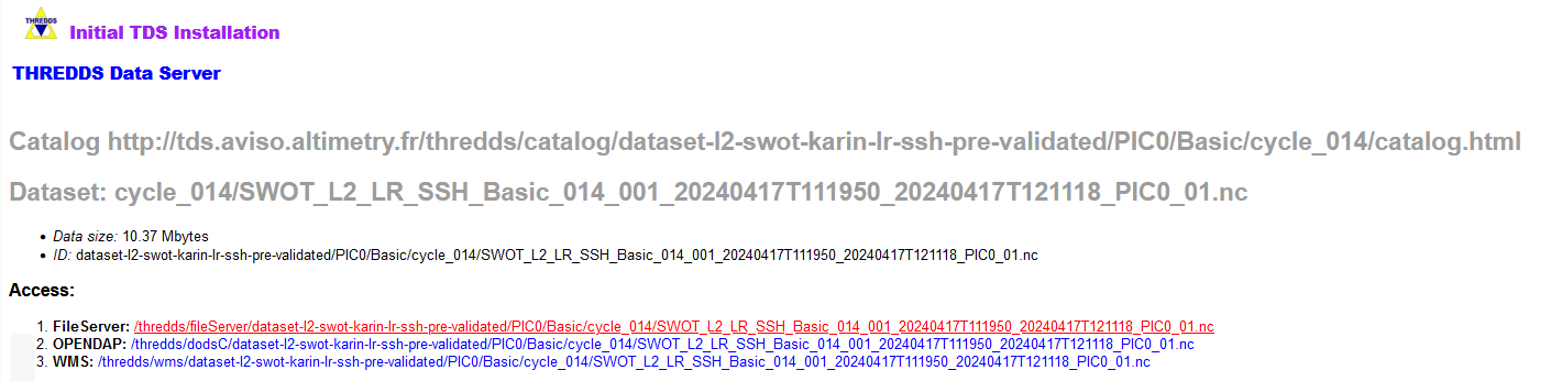

### Swot LR L3 data



In [14]:
# define files to be downloaded
# Science phase
cycle = np.arange(1,37)
#passes = [7, 20, 35, 46, 48, 61, 63, 74, 89, 102, 117, 130, 145, 158, 173, 186, 201, 214, 229, 242, 257,
          #268, 270, 296, 298, 324, 326, 339, 341, 352, 367, 386, 395, 408, 423, 436, 451, 464, 479, 492,
          #507, 520, 535, 548, 563, 576]

# CalVal phase
#cycle = np.arange(577,579)
#passes = [7, 9, 16, 18, 20]

#passes=[5, 7, 14, 16, 18, 33, 35, 42, 44, 46, 61, 63, 70, 72, 74, 89, 98, 100, 102, 117, 126, 128, 130, 145, 154, 156, 158, 173, 182, 184, 186, 201, 210, 212, 214, 229, 238, 240, 242, 257, 266, 268, 283, 285, 292, 294, 296, 311, 313, 320, 322, 324, 339, 341, 348, 350, 352, 367, 376, 378, 380, 395, 404, 406, 408, 423, 432, 434, 436, 451, 460, 462, 464, 479, 488, 490, 492, 507, 516, 518, 520, 535, 544, 546, 563, 572, 574]


# passes = [46, 201, 479]
# passes= [18, 46, 74, 89, 145]
passes= [173, 201, 268, 296, 324, 352, 367, 380, 395, 423, 451, 546, 574, 479]

In [15]:
for c in cycle:
    # Replace this URL with the URL of your THREDDS catalog
    # catalog_url = f'https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_{c:03}/catalog.html'
    catalog_url = f'https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_{c:03}/catalog.html'
    # Create a TDSCatalog object
    catalog = TDSCatalog(catalog_url)
    # Get the list of datasets in the catalog
    datasets = catalog.datasets
    # print(datasets)
    
    
    # find matching file names
    # Function to extract cycle and pass numbers
    def extract_cycle_and_pass(filename):
        match = re.search(r"Expert_(\d{3})_(\d{3})_", str(filename))  # Extract cycle and pass numbers
        if match:
            cycle_number = int(match.group(1))  # First three digits
            pass_number = int(match.group(2))   # Next three digits
            return cycle_number, pass_number
        return None, None
    
    # create list with filenames of selected passes for each cycle
    def find_filename(c,passes):
        filelist = []
        # Identify files with correct pass numbers
        for file in datasets:
            c, pass_num = extract_cycle_and_pass(file)
            if pass_num in passes:
                filelist.append(file)
        return filelist
    
    list_cycle = find_filename(c,passes)

    for i in range(len(list_cycle)):
        # l3_dataset_url = f"https://tds.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_{c:03}/{list_cycle[i]}"
        l3_dataset_url = f"https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_{c:03}/{list_cycle[i]}"
        l3_file = http_download_file(l3_dataset_url, output_dir,list_cycle[i])
        print(f'{l3_dataset_url} downloaded')

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_001/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_001/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_001/SWOT_L3_LR_SSH_Expert_001_173_20230727T090240_20230727T095406_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_001/SWOT_L3_LR_SSH_Expert_001_201_20230728T090311_20230728T095437_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_001/SWOT_L3_LR_SSH_Expert_001_268_20230730T183009_20230730T192135_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_001/SWOT_L3_LR_SSH_Expert_001_296_20230731T183040_20230731T192206_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_001/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_002/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_002/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_002/SWOT_L3_LR_SSH_Expert_002_173_20230817T054746_20230817T063912_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_002/SWOT_L3_LR_SSH_Expert_002_201_20230818T054817_20230818T063943_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_002/SWOT_L3_LR_SSH_Expert_002_268_20230820T151514_20230820T160640_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_002/SWOT_L3_LR_SSH_Expert_002_296_20230821T151545_20230821T160711_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_002/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_003/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_003/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_003/SWOT_L3_LR_SSH_Expert_003_173_20230907T023252_20230907T032418_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_003/SWOT_L3_LR_SSH_Expert_003_201_20230908T023323_20230908T032449_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_003/SWOT_L3_LR_SSH_Expert_003_268_20230910T120020_20230910T125146_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_003/SWOT_L3_LR_SSH_Expert_003_296_20230911T120051_20230911T125218_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_003/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_004/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_004/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_004/SWOT_L3_LR_SSH_Expert_004_173_20230927T231755_20230928T000922_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_004/SWOT_L3_LR_SSH_Expert_004_201_20230928T231826_20230929T000952_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_004/SWOT_L3_LR_SSH_Expert_004_268_20231001T084523_20231001T093649_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_004/SWOT_L3_LR_SSH_Expert_004_296_20231002T084554_20231002T093720_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_004/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_005/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_005/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_005/SWOT_L3_LR_SSH_Expert_005_173_20231018T200259_20231018T205425_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_005/SWOT_L3_LR_SSH_Expert_005_201_20231019T200330_20231019T205456_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_005/SWOT_L3_LR_SSH_Expert_005_268_20231022T053027_20231022T062153_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_005/SWOT_L3_LR_SSH_Expert_005_296_20231023T053058_20231023T062224_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_005/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_006/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_006/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_006/SWOT_L3_LR_SSH_Expert_006_173_20231108T164804_20231108T173931_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_006/SWOT_L3_LR_SSH_Expert_006_201_20231109T164835_20231109T174001_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_006/SWOT_L3_LR_SSH_Expert_006_268_20231112T021532_20231112T030659_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_006/SWOT_L3_LR_SSH_Expert_006_296_20231113T021603_20231113T030730_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_006/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_007/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_007/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_007/SWOT_L3_LR_SSH_Expert_007_173_20231129T133310_20231129T142436_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_007/SWOT_L3_LR_SSH_Expert_007_201_20231130T133341_20231130T142507_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_007/SWOT_L3_LR_SSH_Expert_007_268_20231202T230038_20231202T235204_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_007/SWOT_L3_LR_SSH_Expert_007_296_20231203T230109_20231203T235235_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_007/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_008/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_008/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_008/SWOT_L3_LR_SSH_Expert_008_173_20231220T101814_20231220T110940_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_008/SWOT_L3_LR_SSH_Expert_008_201_20231221T101845_20231221T111011_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_008/SWOT_L3_LR_SSH_Expert_008_423_20231229T084001_20231229T093127_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_008/SWOT_L3_LR_SSH_Expert_008_451_20231230T084032_20231230T093158_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_008/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_009/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_009/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_009/SWOT_L3_LR_SSH_Expert_009_173_20240110T070319_20240110T075445_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_009/SWOT_L3_LR_SSH_Expert_009_201_20240111T070350_20240111T075516_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_009/SWOT_L3_LR_SSH_Expert_009_268_20240113T163047_20240113T172214_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_009/SWOT_L3_LR_SSH_Expert_009_296_20240114T163119_20240114T172245_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_009/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_010/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_010/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_010/SWOT_L3_LR_SSH_Expert_010_173_20240131T034825_20240131T043952_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_010/SWOT_L3_LR_SSH_Expert_010_201_20240201T034856_20240201T044023_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_010/SWOT_L3_LR_SSH_Expert_010_268_20240203T131554_20240203T140720_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_010/SWOT_L3_LR_SSH_Expert_010_296_20240204T131625_20240204T140751_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_010/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_011/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_011/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_011/SWOT_L3_LR_SSH_Expert_011_173_20240221T003330_20240221T012457_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_011/SWOT_L3_LR_SSH_Expert_011_201_20240222T003401_20240222T012528_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_011/SWOT_L3_LR_SSH_Expert_011_268_20240224T100059_20240224T105225_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_011/SWOT_L3_LR_SSH_Expert_011_296_20240225T100130_20240225T105256_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_011/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_012/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_012/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_012/SWOT_L3_LR_SSH_Expert_012_173_20240312T211833_20240312T220959_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_012/SWOT_L3_LR_SSH_Expert_012_201_20240313T211904_20240313T221030_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_012/SWOT_L3_LR_SSH_Expert_012_268_20240316T064601_20240316T073727_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_012/SWOT_L3_LR_SSH_Expert_012_296_20240317T064632_20240317T073758_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_012/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_013/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_013/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_013/SWOT_L3_LR_SSH_Expert_013_173_20240402T180337_20240402T185504_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_013/SWOT_L3_LR_SSH_Expert_013_201_20240403T180408_20240403T185534_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_013/SWOT_L3_LR_SSH_Expert_013_268_20240406T033105_20240406T042231_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_013/SWOT_L3_LR_SSH_Expert_013_296_20240407T033137_20240407T042303_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_013/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_014/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_014/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_014/SWOT_L3_LR_SSH_Expert_014_173_20240423T144844_20240423T154010_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_014/SWOT_L3_LR_SSH_Expert_014_201_20240424T144915_20240424T154041_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_014/SWOT_L3_LR_SSH_Expert_014_268_20240427T001611_20240427T010738_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_014/SWOT_L3_LR_SSH_Expert_014_296_20240428T001642_20240428T010809_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_014/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_015/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_015/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_015/SWOT_L3_LR_SSH_Expert_015_173_20240514T113348_20240514T122514_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_015/SWOT_L3_LR_SSH_Expert_015_201_20240515T113419_20240515T122545_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_015/SWOT_L3_LR_SSH_Expert_015_268_20240517T210116_20240517T215242_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_015/SWOT_L3_LR_SSH_Expert_015_296_20240518T210147_20240518T215313_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_015/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_016/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_016/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_016/SWOT_L3_LR_SSH_Expert_016_173_20240604T081854_20240604T091020_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_016/SWOT_L3_LR_SSH_Expert_016_201_20240605T081925_20240605T091051_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_016/SWOT_L3_LR_SSH_Expert_016_296_20240608T174652_20240608T183818_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_016/SWOT_L3_LR_SSH_Expert_016_324_20240609T174723_20240609T183849_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_016/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_017/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_017/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_017/SWOT_L3_LR_SSH_Expert_017_173_20240625T050357_20240625T055523_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_017/SWOT_L3_LR_SSH_Expert_017_201_20240626T050428_20240626T055554_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_017/SWOT_L3_LR_SSH_Expert_017_268_20240628T143125_20240628T152251_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_017/SWOT_L3_LR_SSH_Expert_017_296_20240629T143156_20240629T152322_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_017/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_018/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_018/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_018/SWOT_L3_LR_SSH_Expert_018_173_20240716T014901_20240716T024027_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_018/SWOT_L3_LR_SSH_Expert_018_201_20240717T014932_20240717T024059_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_018/SWOT_L3_LR_SSH_Expert_018_268_20240719T111630_20240719T120756_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_018/SWOT_L3_LR_SSH_Expert_018_296_20240720T111701_20240720T120827_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_018/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_019/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_019/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_019/SWOT_L3_LR_SSH_Expert_019_173_20240805T223405_20240805T232532_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_019/SWOT_L3_LR_SSH_Expert_019_201_20240806T223437_20240806T232603_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_019/SWOT_L3_LR_SSH_Expert_019_268_20240809T080134_20240809T085300_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_019/SWOT_L3_LR_SSH_Expert_019_296_20240810T080205_20240810T085332_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_019/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_020/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_020/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_020/SWOT_L3_LR_SSH_Expert_020_173_20240826T191910_20240826T201036_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_020/SWOT_L3_LR_SSH_Expert_020_201_20240827T191941_20240827T201107_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_020/SWOT_L3_LR_SSH_Expert_020_268_20240830T044639_20240830T053805_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_020/SWOT_L3_LR_SSH_Expert_020_296_20240831T044710_20240831T053836_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_020/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_021/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_021/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_021/SWOT_L3_LR_SSH_Expert_021_173_20240916T160416_20240916T165542_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_021/SWOT_L3_LR_SSH_Expert_021_201_20240917T160447_20240917T165614_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_021/SWOT_L3_LR_SSH_Expert_021_268_20240920T013145_20240920T022312_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_021/SWOT_L3_LR_SSH_Expert_021_296_20240921T013217_20240921T022343_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_021/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_022/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_022/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_022/SWOT_L3_LR_SSH_Expert_022_173_20241007T124923_20241007T134049_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_022/SWOT_L3_LR_SSH_Expert_022_201_20241008T124954_20241008T134120_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_022/SWOT_L3_LR_SSH_Expert_022_268_20241010T221651_20241010T230817_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_022/SWOT_L3_LR_SSH_Expert_022_296_20241011T221721_20241011T230848_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_022/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_023/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_023/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_023/SWOT_L3_LR_SSH_Expert_023_201_20241029T093458_20241029T102624_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_023/SWOT_L3_LR_SSH_Expert_023_268_20241031T190154_20241031T195321_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_023/SWOT_L3_LR_SSH_Expert_023_296_20241101T190225_20241101T195352_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_023/SWOT_L3_LR_SSH_Expert_023_324_20241102T190257_20241102T195423_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_023/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_024/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_024/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_024/SWOT_L3_LR_SSH_Expert_024_173_20241118T061931_20241118T071058_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_024/SWOT_L3_LR_SSH_Expert_024_201_20241119T062003_20241119T071129_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_024/SWOT_L3_LR_SSH_Expert_024_268_20241121T154700_20241121T163826_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_024/SWOT_L3_LR_SSH_Expert_024_296_20241122T154731_20241122T163858_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_024/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_025/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_025/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_025/SWOT_L3_LR_SSH_Expert_025_173_20241209T030436_20241209T035602_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_025/SWOT_L3_LR_SSH_Expert_025_201_20241210T030507_20241210T035633_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_025/SWOT_L3_LR_SSH_Expert_025_268_20241212T123204_20241212T132330_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_025/SWOT_L3_LR_SSH_Expert_025_296_20241213T123235_20241213T132401_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_025/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_026/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_026/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_026/SWOT_L3_LR_SSH_Expert_026_173_20241229T234941_20241230T004107_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_026/SWOT_L3_LR_SSH_Expert_026_201_20241230T235012_20241231T004138_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_026/SWOT_L3_LR_SSH_Expert_026_268_20250102T091709_20250102T100835_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_026/SWOT_L3_LR_SSH_Expert_026_296_20250103T091740_20250103T100906_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_026/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_027/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_027/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_027/SWOT_L3_LR_SSH_Expert_027_173_20250119T203445_20250119T212611_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_027/SWOT_L3_LR_SSH_Expert_027_201_20250120T203516_20250120T212643_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_027/SWOT_L3_LR_SSH_Expert_027_268_20250123T060214_20250123T065340_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_027/SWOT_L3_LR_SSH_Expert_027_296_20250124T060245_20250124T065411_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_027/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_028/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_028/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_028/SWOT_L3_LR_SSH_Expert_028_173_20250209T171948_20250209T181114_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_028/SWOT_L3_LR_SSH_Expert_028_201_20250210T172019_20250210T181146_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_028/SWOT_L3_LR_SSH_Expert_028_268_20250213T024717_20250213T033843_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_028/SWOT_L3_LR_SSH_Expert_028_296_20250214T024748_20250214T033914_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_028/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_029/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_029/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_029/SWOT_L3_LR_SSH_Expert_029_173_20250302T140454_20250302T145620_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_029/SWOT_L3_LR_SSH_Expert_029_201_20250303T140525_20250303T145651_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_029/SWOT_L3_LR_SSH_Expert_029_268_20250305T233221_20250306T002348_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_029/SWOT_L3_LR_SSH_Expert_029_296_20250306T233252_20250307T002418_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_029/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_030/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_030/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_030/SWOT_L3_LR_SSH_Expert_030_173_20250323T104959_20250323T114125_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_030/SWOT_L3_LR_SSH_Expert_030_201_20250324T105030_20250324T114156_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_030/SWOT_L3_LR_SSH_Expert_030_268_20250326T201727_20250326T210853_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_030/SWOT_L3_LR_SSH_Expert_030_296_20250327T201758_20250327T210924_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_030/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_031/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_031/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_031/SWOT_L3_LR_SSH_Expert_031_173_20250413T073503_20250413T082630_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_031/SWOT_L3_LR_SSH_Expert_031_201_20250414T073534_20250414T082700_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_031/SWOT_L3_LR_SSH_Expert_031_268_20250416T170232_20250416T175358_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_031/SWOT_L3_LR_SSH_Expert_031_296_20250417T170303_20250417T175429_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_031/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_032/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_032/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_032/SWOT_L3_LR_SSH_Expert_032_173_20250504T042007_20250504T051133_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_032/SWOT_L3_LR_SSH_Expert_032_201_20250505T042038_20250505T051205_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_032/SWOT_L3_LR_SSH_Expert_032_268_20250507T134735_20250507T143901_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_032/SWOT_L3_LR_SSH_Expert_032_296_20250508T134806_20250508T143932_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_032/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_033/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_033/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_033/SWOT_L3_LR_SSH_Expert_033_173_20250525T010513_20250525T015639_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_033/SWOT_L3_LR_SSH_Expert_033_201_20250526T010544_20250526T015710_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_033/SWOT_L3_LR_SSH_Expert_033_268_20250528T103242_20250528T112408_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_033/SWOT_L3_LR_SSH_Expert_033_296_20250529T103313_20250529T112439_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_033/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_034/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_034/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_034/SWOT_L3_LR_SSH_Expert_034_173_20250614T215017_20250614T224144_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_034/SWOT_L3_LR_SSH_Expert_034_201_20250615T215048_20250615T224214_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_034/SWOT_L3_LR_SSH_Expert_034_268_20250618T071745_20250618T080911_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_034/SWOT_L3_LR_SSH_Expert_034_296_20250619T071816_20250619T080942_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_034/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_035/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_035/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_035/SWOT_L3_LR_SSH_Expert_035_173_20250705T183524_20250705T192650_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_035/SWOT_L3_LR_SSH_Expert_035_201_20250706T183555_20250706T192721_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_035/SWOT_L3_LR_SSH_Expert_035_268_20250709T040252_20250709T045419_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_035/SWOT_L3_LR_SSH_Expert_035_296_20250710T040323_20250710T045450_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_035/SWOT_L3_LR_SSH_Expert_0

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_44309/1968163690.py:6: UserWarning: URL https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_036/catalog.html returned HTML. Changing to: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_036/catalog.xml
  catalog = TDSCatalog(catalog_url)


https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_036/SWOT_L3_LR_SSH_Expert_036_173_20250726T152029_20250726T161155_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_036/SWOT_L3_LR_SSH_Expert_036_201_20250727T152100_20250727T161226_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_036/SWOT_L3_LR_SSH_Expert_036_268_20250730T004757_20250730T013923_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_036/SWOT_L3_LR_SSH_Expert_036_296_20250731T004828_20250731T013954_v2.0.1.nc downloaded
https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Expert/cycle_036/SWOT_L3_LR_SSH_Expert_0